In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.cuda.is_available()

False

## Data

In [2]:
patient1 = np.load("patient1.npy")
patient2 = np.load("patient2.npy")

In [3]:
patient1.shape

(30, 4726)

In [4]:
patient2.shape

(109, 4726)

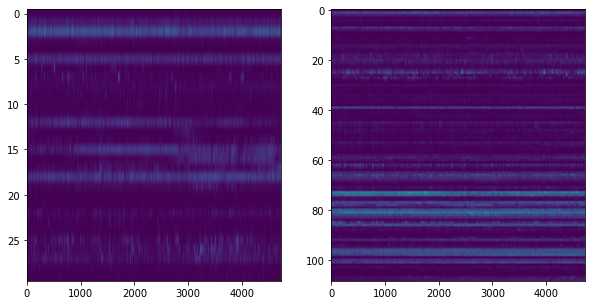

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(patient1, aspect="auto")
ax2.imshow(patient2, aspect="auto")

In [9]:
from torch.utils.data import TensorDataset, DataLoader

In [89]:
patient1_train = patient1.T[:-700].astype(np.float32)
patient2_train = patient2.T[:-700].astype(np.float32)

patient1_test = patient1.T[-650:].astype(np.float32)
patient2_test = patient2.T[-650:].astype(np.float32)

x_and_y_train = TensorDataset(
    torch.from_numpy(patient1_train), 
    torch.from_numpy(patient2_train)
)
trainloader = DataLoader(x_and_y, batch_size=64, shuffle=True)

x_and_y_test = TensorDataset(
    torch.from_numpy(patient1_test), 
    torch.from_numpy(patient2_test)
)
testloader = DataLoader(x_and_y, batch_size=64, shuffle=False)

In [90]:
for x, y in trainloader:
    break
x

tensor([[0., 1., 4.,  ..., 0., 0., 0.],
        [0., 0., 3.,  ..., 0., 0., 0.],
        [0., 0., 3.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 3.,  ..., 1., 0., 0.],
        [0., 2., 3.,  ..., 0., 1., 0.],
        [0., 1., 3.,  ..., 0., 0., 0.]])

In [91]:
x.shape, y.shape

(torch.Size([64, 30]), torch.Size([64, 109]))

## Model

In [93]:
from torch import nn

class CCAModel(nn.Module):
    def __init__(self, data_dim, k):
        super().__init__()
        self.linear_mapping = nn.Linear(data_dim, k, bias=False)
        
    def forward(self, x):
        return self.linear_mapping(x)

In [94]:
k = 5

x_dim = x.shape[1]
u_model = CCAModel(x_dim, k)

y_dim = y.shape[1]
v_model = CCAModel(y_dim, k)

In [95]:
u = u_model(x)
v = v_model(y)

## Pre-compute X and Y covariance

In [105]:
patient1_train_mean0 = patient1_train - patient1_train.mean(axis=0, keepdims=True)
patient2_train_mean0 = patient2_train - patient2_train.mean(axis=0, keepdims=True)

x_cov = (patient1_train_mean0.T @ patient1_train_mean0) / len(patient1_train_mean0)
x_cov = torch.from_numpy(x_cov)
y_cov = (patient2_train_mean0.T @ patient2_train_mean0) / len(patient2_train_mean0)
y_cov = torch.from_numpy(y_cov)

## Building the objective function

In [134]:
u_idx = 0
a_outer_product = u_model.linear_mapping.weight[[u_idx]].T @ u_model.linear_mapping.weight[[u_idx]]
u_var = (a_outer_product * x_cov).sum()